# Multiple linear regression

## Grading the professor

Many college courses conclude by giving students the opportunity to evaluate the course and the instructor anonymously. However, the use of these student evaluations as an indicator of course quality and teaching effectiveness is often criticized because these measures may reflect the influence of non-teaching related characteristics, such as the physical appearance of the instructor. The article titled, "Beauty in the classroom: instructors' pulchritude and putative pedagogical productivity" (Hamermesh and Parker, 2005) found that instructors who are viewed to be better looking receive higher instructional ratings. (Daniel S. Hamermesh, Amy Parker, Beauty in the classroom: instructors pulchritude and putative pedagogical productivity, *Economics of Education Review*, Volume 24, Issue 4, August 2005, Pages 369-376, ISSN 0272-7757, 10.1016/j.econedurev.2004.07.013. http://www.sciencedirect.com/science/article/pii/S0272775704001165.)

In this lab we will analyze the data from this study in order to learn what goes into a positive professor evaluation.

## The data

The data were gathered from end of semester student evaluations for a large sample of professors from the University of Texas at Austin. In addition, six students rated the professors' physical appearance. (This is aslightly modified version of the original data set that was released as part of the replication data for *Data Analysis Using Regression and Multilevel/Hierarchical Models* (Gelman and Hill, 2007).) The result is a data frame where each row contains a different course and columns represent variables about the courses and professors

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests

df_url = 'https://raw.githubusercontent.com/akmand/datasets/master/openintro/evals.csv'
url_content = requests.get(df_url, verify=False).content
evals = pd.read_csv(io.StringIO(url_content.decode('utf-8')))

variable         | description
---------------- | -----------
`score`          | average professor evaluation score: (1) very unsatisfactory - (5) excellent.
`rank`           | rank of professor: teaching, tenure track, tenured.
`ethnicity`      | ethnicity of professor: not minority, minority.
`gender`         | gender of professor: female, male.
`language`       | language of school where professor received education: english or non-english.
`age`            | age of professor.
`cls_perc_eval`  | percent of students in class who completed evaluation.
`cls_did_eval`   | number of students in class who completed evaluation.
`cls_students`   | total number of students in class.
`cls_level`      | class level: lower, upper.
`cls_profs`      | number of professors teaching sections in course in sample: single, multiple.
`cls_credits`    | number of credits of class: one credit (lab, PE, etc.), multi credit.
`bty_f1lower`    | beauty rating of professor from lower level female: (1) lowest - (10) highest.
`bty_f1upper`    | beauty rating of professor from upper level female: (1) lowest - (10) highest.
`bty_f2upper`    | beauty rating of professor from second upper level female: (1) lowest - (10) highest.
`bty_m1lower`    | beauty rating of professor from lower level male: (1) lowest - (10) highest.
`bty_m1upper`    | beauty rating of professor from upper level male: (1) lowest - (10) highest.
`bty_m2upper`    | beauty rating of professor from second upper level male: (1) lowest - (10) highest.
`bty_avg`        | average beauty rating of professor.
`pic_outfit`     | outfit of professor in picture: not formal, formal.
`pic_color`      | color of professor's picture: color, black & white.

## Exploring the data

<div class = 'exercise'>
<h4>Exercise 1</h4>
Is this an observational study or an experiment? The original research question posed in the paper is whether beauty leads directly to the differences in course evaluations. Given the study design, is it possible to answer this question as it is phrased? If not, rephrase the question.
</div>

<div class = 'exercise'>
<h4>Exercise 2</h4>
Describe the distribution of <code>score</code>. Is the distribution skewed? What does that tell you about how students rate courses? Is this what you expected to see? Why, or why not?
</div>

<div class = 'exercise'>
<h4>Exercise 3</h4>
    Excluding <code>score</code>, select two other variables and describe their relationship using an appropriate visualization (scatterplot, side-by-side boxplots, or mosaic plot).
</div>

## Simple linear regression

The fundamental phenomenon suggested by the study is that better looking teachers are evaluated more favorably. Let's create a scatterplot to see if this appears to be the case:

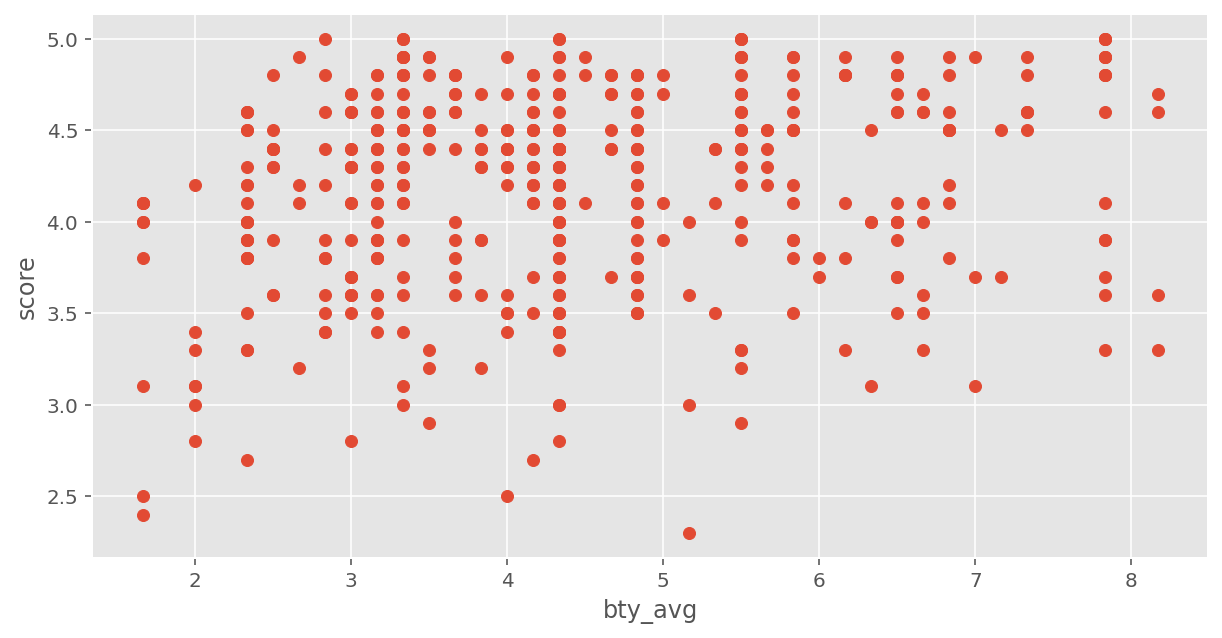

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

plt.scatter(evals.bty_avg, evals.score)
plt.xlabel('bty_avg')
plt.ylabel('score')
plt.show();

Before we draw conclusions about the trend, compare the number of observations in the data frame with the approximate number of points on the scatterplot. Is anything awry?

<div class = 'exercise'>
<h4>Exercise 4</h4>
Replot the scatterplot, but this time add jitter on the y- or the x-coordinate. What was misleading about the initial scatterplot?
</div>

<div class = 'exercise'>
<h4>Exercise 5</h4>
Let's see if the apparent trend in the plot is something more than natural variation. Fit a linear model called <code>m_bty</code> to predict average professor score by average beauty rating and add the line to your plot. Write out the equation for the linear model and interpret the slope. Is average beauty score a statistically significant predictor? Does it appear to be a practically significant predictor?
</div>

<div class = 'exercise'>
<h4>Exercise 6</h4>
Use residual plots to evaluate whether the conditions of least squares regression are reasonable. Provide plots and comments for each one (see the Simple Regression Lab for a reminder of how to make these).
</div>

## Multiple linear regression

The data set contains several variables on the beauty score of the professor: individual ratings from each of the six students who were asked to score the physical appearance of the professors and the average of these six scores. Let's take a look at the relationship between one of these scores and the average beauty score.

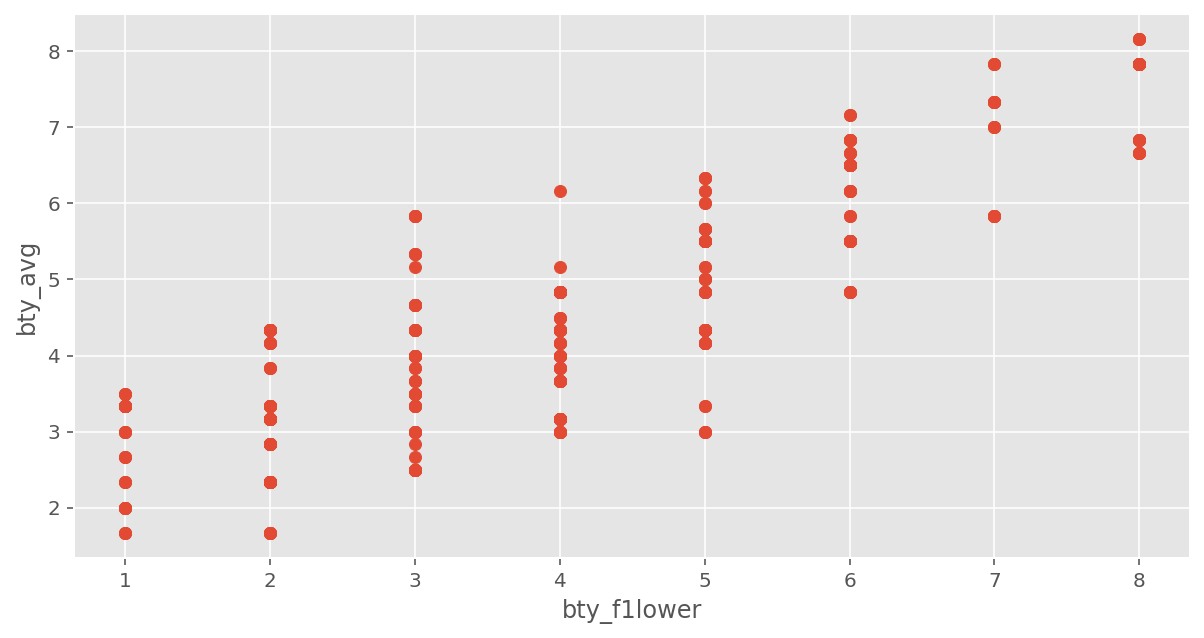

In [3]:
plt.scatter(evals.bty_f1lower, evals.bty_avg)
plt.xlabel('bty_f1lower')
plt.ylabel('bty_avg')
plt.show();

In [4]:
evals.bty_avg.corr(evals.bty_f1lower)

0.8439111692147887

As expected the relationship is quite strong - after all, the average score is calculated using the individual scores. We can actually take a look at the relationships between all beauty variables (columns 13 through 19) by plotting pairwise relationships using `pairplot()` function by `seaborn`:

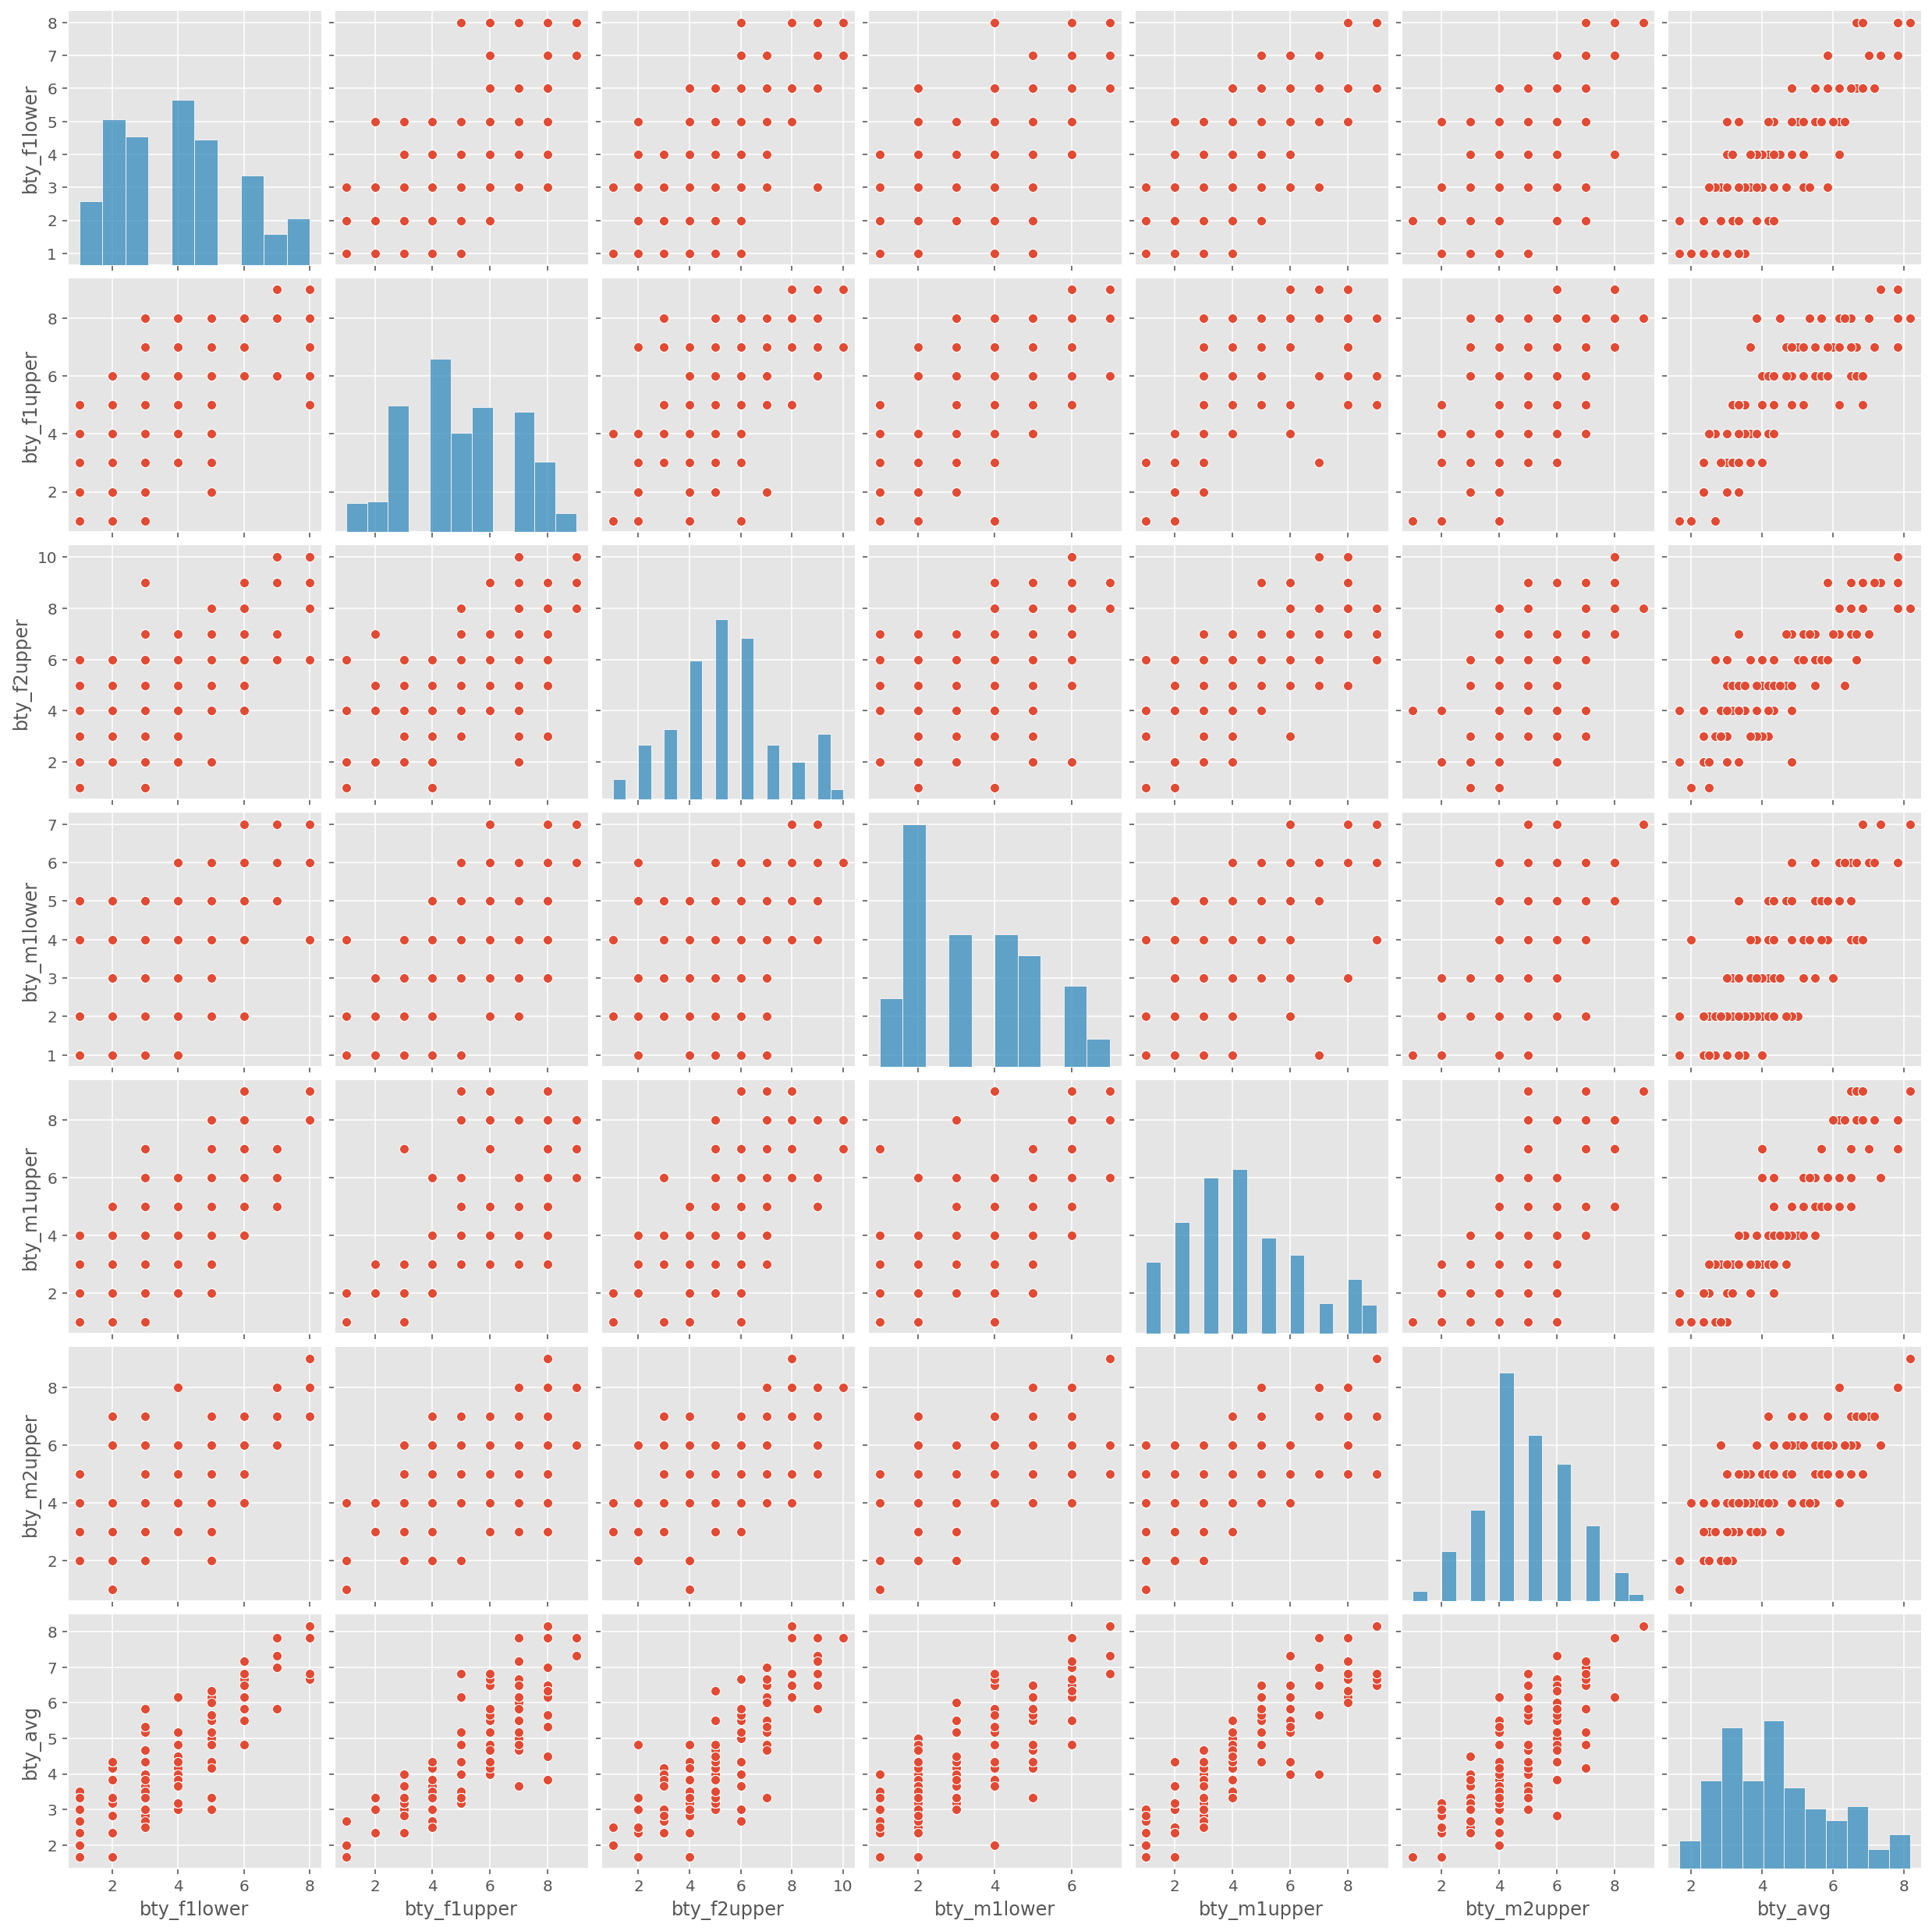

In [5]:
import seaborn as sns

sns.pairplot(evals.iloc[:,12:19])
plt.show();

These variables are collinear (correlated), and adding more than one of these variables to the model would not add much value to the model. In this application and with these highly-correlated predictors, it is reasonable to use the average beauty score as the single representative of these variables.

In order to see if beauty is still a significant predictor of professor score after we've accounted for the gender of the professor, we can add the gender term into the model.

Since `gender` is a nominal category feature, we first need to convert `gender` from having the values of `female` and `male` to being an indicator variable called `gender_integer` that takes a value of `0` for females and a value of `1` for males (Such variables are often referred to as "dummy" variables.). We can use the `replace()` function for integer-encoding. Before using the `replace()` function, we need define a mapping between the levels and the integers using a dictionary as below.

In [6]:
level_mapping = {'female': 0, 'male': 1}

Once we define a mapping, we can define a new variable called `gender_integer` and then perform the integer-encoding using the `replace()` function.

In [7]:
gender_integer = evals['gender'].copy()
gender_integer = gender_integer.replace(level_mapping)
gender_integer.head(5)
evals['gender_integer'] = gender_integer

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = evals[['bty_avg','gender_integer']].copy()
y = np.array(evals.score).reshape((-1, 1))

# model initialization
mlinear_model = LinearRegression()
# fit the data
mlinear_model.fit(x, y)
# predict
y_pred = mlinear_model.predict(x)
print('Slope:', mlinear_model.coef_)
print('Intercept:', mlinear_model.intercept_)
print('R-squared:', r2_score(y, y_pred))

Slope: [[0.07415537 0.17238955]]
Intercept: [3.74733824]
R-squared: 0.05912279033681789


<div class = 'exercise'>
<h4>Exercise 7</h4>
P-values and parameter estimates should only be trusted if the conditions for the regression are reasonable. Verify that the conditions for this model are reasonable using diagnostic plots.
</div>

<div class = 'exercise'>
<h4>Exercise 8</h4>
    Is <code>bty_avg</code> still a significant predictor of <code>score</code>? Has the addition of <code>gender</code> to the model changed the parameter estimate for <code>bty_avg</code>?
</div>

As a result, for females, the parameter estimate is multiplied by zero, leaving the intercept and slope form familiar from simple regression.

#### ${\hat{score}}$ = ${\hat{\beta}}$<sub>0</sub> + ${\hat{\beta}}$<sub>1</sub> ${*}$ *bty_avg* + ${\hat{\beta}}$<sub>2</sub> ${*}$ (0) = ${\hat{\beta}}$<sub>0</sub> + ${\hat{\beta}}$<sub>1</sub> ${*}$ *bty_avg*

We can plot two lines corresponding to males and females.

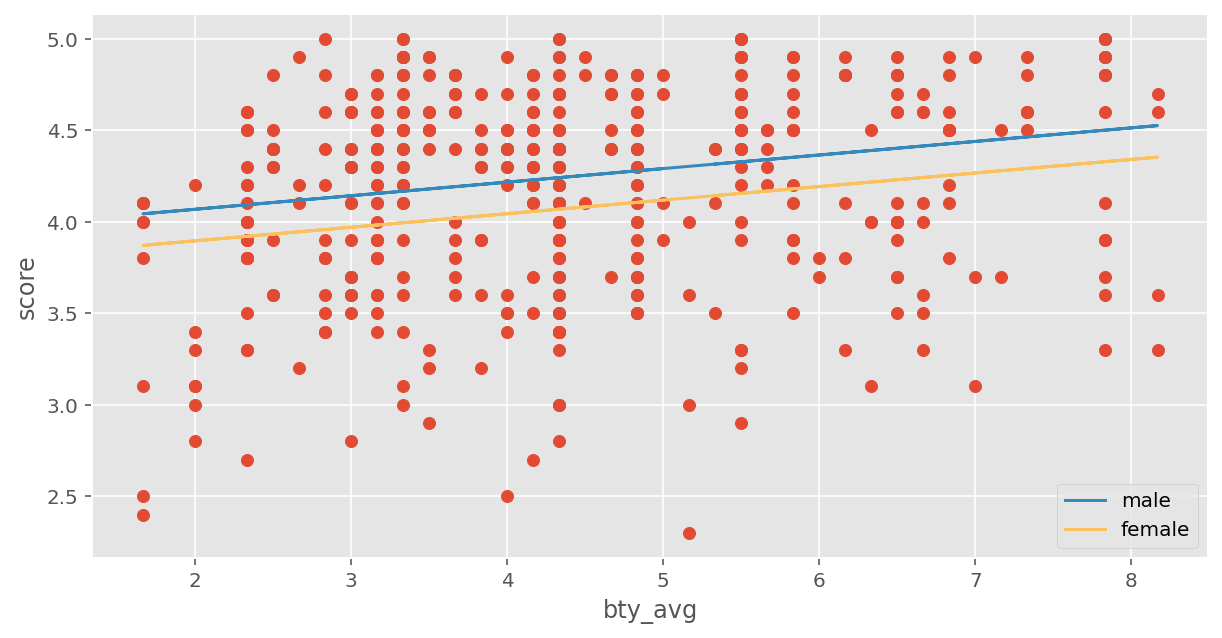

In [9]:
plt.scatter(evals.bty_avg, evals.score, label = '')
plt.xlabel('bty_avg')
plt.ylabel('score')

# male
y_male = 3.74733824 + 0.07415537*evals.bty_avg + 0.17238955*1
plt.plot(evals.bty_avg, y_male, color = 'C8', label = 'male')

# female
y_female = 3.74733824 + 0.07415537*evals.bty_avg + 0.17238955*0
plt.plot(evals.bty_avg, y_female, color = 'C4', label = 'female')

plt.legend(loc = 'lower right')
plt.show();

<div class = 'exercise'>
<h4>Exercise 9</h4>
    What is the equation of the line corresponding to males? (<i>Hint</i>: For males, the parameter estimate is multiplied by 1.) For two professors who received the same beauty rating, which gender tends to have the higher course evaluation score?
</div>

<div class = 'exercise'>
<h4>Exercise 10</h4>
    Create a new model called <code>m_bty_rank</code> with <code>gender</code>  removed and <code>rank</code>  added in. Note that the rank variable has three levels:  <code>teaching</code> , <code>tenure track</code> , <code>tenured</code> .
</div>

The interpretation of the coefficients in multiple regression is slightly different from that of simple regression. The estimate for `bty_avg` reflects how much higher a group of professors is expected to score if they have a beauty rating that is one point higher *while holding all other variables constant*. In this case, that translates into considering only professors of the same rank with `bty_avg` scores that are one point apart.

## The search for the best model

We will start with a full model that predicts professor score based on rank, ethnicity, gender, language of the university where they got their degree, age, proportion of students that filled out evaluations, class size, course level, number of professors, number of credits, average beauty rating, outfit, and picture color.

<div class = 'exercise'>
<h4>Exercise 11</h4>
    Which variable would you expect to have the highest p-value in this model? Why? <i>Hint</i>: Think about which variable would you expect to not have any association with the professor score.
</div>

Let's run the model via `statsmodels`...

In [10]:
import statsmodels.api as sm

m_full = sm.formula.ols(formula = 'score ~ rank + ethnicity + gender + language + age + cls_perc_eval + cls_students + cls_level + cls_profs + cls_credits + bty_avg + pic_outfit + pic_color', data = evals)
multi_reg = m_full.fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     7.366
Date:                Sat, 26 Feb 2022   Prob (F-statistic):           6.55e-14
Time:                        19:36:01   Log-Likelihood:                -326.52
No. Observations:                 463   AIC:                             683.0
Df Residuals:                     448   BIC:                             745.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

<div class = 'exercise'>
<h4>Exercise 12</h4>
Check your suspicions from the previous exercise. Include the model output in your response.
    </div>

<div class = 'exercise'>
<h4>Exercise 13</h4>
Interpret the coefficient associated with the ethnicity variable.    </div>

<div class = 'exercise'>
<h4>Exercise 14</h4>
Drop the variable with the highest p-value and re-fit the model. Did the coefficients and significance of the other explanatory variables change? (One of the things that makes multiple regression interesting is that coefficient estimates depend on the other variables that are included in the model.) If not, what does this say about whether or not the dropped variable was collinear with the other explanatory variables?    </div>

<div class = 'exercise'>
<h4>Exercise 15</h4>
Using backward-selection and p-value as the selection criterion, determine the best model. You do not need to show all steps in your answer, just the output for the final model. Also, write out the linear model for predicting score based on the final model you settle on.    </div>

<div class = 'exercise'>
<h4>Exercise 16</h4>
Verify that the conditions for this model are reasonable using diagnostic plots.    </div>

<div class = 'exercise'>
<h4>Exercise 17</h4>
The original paper describes how these data were gathered by taking a sample of professors from the University of Texas at Austin and including all courses that they have taught. Considering that each row represents a course, could this new information have an impact on any of the conditions of linear regression?    </div>

<div class = 'exercise'>
<h4>Exercise 18</h4>
Based on your final model, describe the characteristics of a professor and course at University of Texas at Austin that would be associated with a high evaluation score.    </div>

<div class = 'exercise'>
<h4>Exercise 19</h4>
Would you be comfortable generalizing your conclusions to apply to professors generally (at any university)? Why or why not?</div>

<div class = "license">
This lab was adapted by David Akman and Imran Ture from OpenIntro by Andrew Bray and Mine Çetinkaya-Rundel.
</div>

***
www.featureranking.com